In [1]:
import numpy
import os
import scipy.sparse as sp
from scipy.io.mmio import mmread
import scipy.io
from random import randint, uniform
import time
import sys
from tqdm import tqdm
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import warnings
import pickle
import tracemalloc

import pandas as pd
import xgboost as xgb
from sklearn import metrics
from xgboost.sklearn import XGBClassifier #sklearn xgboost
from sklearn.model_selection import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

In [2]:
import torch
stat1 = torch.randn(512, dtype=torch.float)
stat1 = stat1.view(1, 512)
stat2 = torch.randn(512, dtype=torch.float)
stat2 = stat2.view(1, 512)
a = torch.cat((stat1, stat2), dim=0)
a.shape

torch.Size([2, 512])

## Dir define

In [10]:
dataset_path = '../dataset/'
root_data = '../dataset/s_mm.txt'
img_path = '../dataset/generated_pic'
spmm_mix_path = '../dataset/spmmData_MIX.csv'
saved_path = '../saved_model/'

## XGBoost

In [4]:
import json

# root_data = 's_mm.txt'
with open(root_data, 'r') as f:
    data = f.readlines()  # 读取文件
    size_data = len(data)
    print(data[size_data - 1])

'''
Time: 2, 10, 18, 26, ...
Mem: 4, 12, 20, 28, ...
Final: 6, 14, 22, 30, ...
The end: size_data - 1

Final
'''
time_ = []
mem = []
final = []
with open(root_data, 'r') as f:
    data = f.readlines()
    for i in range(2, size_data - 1, 8):
        time_list = json.loads(data[i][:-1])
        mem_list = json.loads(data[i+2][:-1])
#         final_list = json.loads(data[i+4][:-1])
        time_.append(time_list)
        mem.append(mem_list)
        final.append(data[i+4][:-1])

time_re = []
for index, i in enumerate(time_):
  time_re.append(i.index(min(i)))

Training data store Done (spmvDataS_10000.csv)


In [5]:
label = range(1,7)
t_ = iter(time_)
m_ = iter(mem)
label_new = []
w_ = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
w = w_[9]
for i in range(252):
  a = next(t_)
  b = next(m_)
  minNorm = (w*numpy.array(a)) + ((1 - w)*numpy.array(b))
  final_dict = dict(zip(label, minNorm))
  final_dict = sorted(final_dict.items(), key = lambda kv:(kv[1], kv[0]))
  label_new.append(final_dict[0][0])


In [6]:
import numpy as np

Y_ = np.array(label_new)
Y_.shape

(252,)

In [11]:
  # load data
  name = ["numRow", "numCol", "NNZ", "Ndiags", "aver_RD", "max_RD", "min_RD","dev_RD", "aver_CD", "max_CD", "min_CD", "dev_CD", "ER_DIA", "ER_RD", "ER_CD", "row_bounce", "col_bounce", "density", "cv", "max_mu","label"]
  dataset = pd.read_csv(spmm_mix_path, header=None, names=name)
  numOfCol = dataset.shape[1]

  # dataset = loadtxt(outputDir + 'spmmData_MIX.csv', delimiter=",", encoding='utf-8')
  numOfCol = dataset.shape[1]

  # split data into X and y
  # X = dataset[:,0:numOfCol-2]
  # Y = dataset[:,numOfCol-1]
  X = dataset.values[:,0:numOfCol-1]
  Y = dataset.values[:,numOfCol-1]


  kf = KFold(n_splits=5)
  kf.get_n_splits(X)

  # creating accuracy array for storing accuracy from each fold of 5 fold cross validation
  accracyArr = numpy.full(5, 0, float)
  accuracyCounter = 0

  feature_name = name[:-1]

  for trainIndex, testIndex in kf.split(X):
  #     print("TRAIN: ", trainIndex, "TEST: ", testIndex)
      xTrain, xTest = X[trainIndex], X[testIndex]
      # yTrain, yTest = Y[trainIndex], Y[testIndex]
      yTrain, yTest = Y_[trainIndex], Y_[testIndex]
      

      
      # fit model on training data
      model = XGBClassifier()
      bst = model.fit(xTrain, yTrain)
      bst.save_model(saved_path + 'xgb_Time.model')

      # make predictions for test data
      start = time.time()
      yPred = model.predict(xTest)
      print(yPred)
      end = time.time()
      predictions = [round(value) for value in yPred]

      # evaluate predictions
      accracyArr[accuracyCounter] = accuracy_score(yTest, predictions)
      accuracyCounter = accuracyCounter + 1

  # taking mean of accuracy of each fold from 5 fold cross validation
  accuracyMean = numpy.mean(accracyArr)
  print("Accuracy: %.2f%%" % (accuracyMean * 100.0))
  print("Inference Time: %.4f" % (end - start))
  # Save the model
  pickle.dump(model, open(saved_path + "pimaSync.pickle.dat", "wb"))

[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 5 5 5 6
 5 5 5 6 6 5 5 6 6 5 5 6 6 5]
[5 6 6 5 5 6 6 5 5 6 6 5 5 6 6 5 5 6 6 5 5 6 6 5 5 6 6 5 5 6 6 5 5 6 6 5 5
 6 6 5 5 6 6 5 5 6 6 5 5 6 6]
[5 5 6 6 5 5 6 6 5 5 6 6 5 5 6 6 5 5 6 6 5 5 6 6 5 5 6 6 5 5 6 6 5 5 6 6 5
 5 6 6 5 5 6 6 5 5 6 6 5 5]
[6 6 5 5 6 6 5 5 6 6 5 5 6 6 5 5 6 6 5 5 6 6 5 5 6 6 5 5 6 6 5 5 6 6 5 5 6
 6 5 5 6 6 5 5 6 6 5 5 6 6]
[5 5 6 6 5 5 6 6 5 5 6 6 5 5 3 6 5 5 6 6 5 5 6 6 5 5 6 6 5 5 6 6 5 5 6 6 5
 5 4 6 5 5 6 6 5 5 6 6 5 5]
Accuracy: 88.95%
Inference Time: 0.0009


## CNN

In [13]:
!tar -xvf ./dataset/generated_pic.tar

generated_pic/
generated_pic/10000_0.001.png
generated_pic/10000_0.01.png
generated_pic/10000_0.3.png
generated_pic/10000_0.5.png
generated_pic/1000_0.001.png
generated_pic/1000_0.01.png
generated_pic/1000_0.3.png
generated_pic/1000_0.5.png
generated_pic/10200_0.001.png
generated_pic/10200_0.01.png
generated_pic/10200_0.3.png
generated_pic/10200_0.5.png
generated_pic/10400_0.001.png
generated_pic/10400_0.01.png
generated_pic/10400_0.3.png
generated_pic/10400_0.5.png
generated_pic/10600_0.001.png
generated_pic/10600_0.01.png
generated_pic/10600_0.3.png
generated_pic/10600_0.5.png
generated_pic/10800_0.001.png
generated_pic/10800_0.01.png
generated_pic/10800_0.3.png
generated_pic/10800_0.5.png
generated_pic/11000_0.001.png
generated_pic/11000_0.01.png
generated_pic/11000_0.3.png
generated_pic/11000_0.5.png
generated_pic/11200_0.001.png
generated_pic/11200_0.01.png
generated_pic/11200_0.3.png
generated_pic/11200_0.5.png
generated_pic/11400_0.001.png
generated_pic/11400_0.01.png
generated_

### Generate Images

In [ ]:
import numpy as np
import scipy.sparse as ss
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

def ran_matrix_size(begin_num=11800, tol_num=9, interval=200):
    matrix_size = []
    num = 0
    for i in range(tol_num):
        if i == 0:
            num = begin_num
        else:
            num = begin_num + i * interval
        matrix_size.append(num)
    return matrix_size


density = [0.3,0.5,0.01,0.001] # 70%， 50%， 10%， 99.9%
matrix_X = ran_matrix_size()


for i in matrix_X:
  for j in density:
    num_ele = int(i * i * j) 
    a = [np.random.randint(0,i) for _ in range(num_ele)]
    b = [np.random.randint(0,i) for _ in range(num_ele-i)] + [i for i in range(i)]
    c = np.ones(num_ele)
    rows, cols, v = np.array(a), np.array(b), np.array(c)
    sparseX = ss.coo_matrix((v,(rows,cols)))
    X = sparseX.todense()
    plt.figure(figsize=(25,25))
    plt.imshow(X, vmin=0, vmax=1, cmap='binary')
    plt.xticks([])
    plt.yticks([])
    plt.savefig(fname=dataset_path + '/generated_pic/{}_{}.png'.format(i, j))
    plt.clf()

### Preparing Data and begin training

In [ ]:
import torch.utils.data as data
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, utils
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os
import os.path
import glob

from PIL import Image
import time


name = ["numRow", "numCol", "NNZ", "Ndiags", "aver_RD", "max_RD", "min_RD","dev_RD", "aver_CD", "max_CD", "min_CD", "dev_CD", "ER_DIA", "ER_RD", "ER_CD", "row_bounce", "col_bounce", "density", "cv", "max_mu","label"]
dataset = pd.read_csv('spmmData_MIX.csv', names=name)
numOfCol = dataset.shape[1]
numOfCol = dataset.shape[1]
X = dataset.values[:,0:numOfCol-1]
Y = dataset.values[:,numOfCol-1]

data_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                  std=[0.229, 0.224, 0.225])])

def make_dataset(dirimg, target):
  dataset = []
  count = 0
  for fGT in glob.glob(os.path.join(dirimg, '*.png')):
    fName = os.path.basename(fGT)
    if count < 232:
      dataset.append([os.path.join(dirimg, fName), int(label[count])])
    count += 1
  return dataset


class MyTrainData(torch.utils.data.Dataset):
  def __init__(self, target, transform=None, img_path=img_path):
    dataset = []
    count = 0
    for fGT in glob.glob(os.path.join(img_path, '*.png')):
      fName = os.path.basename(fGT)
      if count < 232:
        dataset.append([os.path.join(img_path, fName), int(target[count])])
      count += 1

    self.img_path = img_path
    self.imgs = dataset
    self.transform = transform

  # Return [img, label], read imgs by index
  def __getitem__(self, index):
    fn, label = self.imgs[index]
    img = Image.open(fn).convert('RGB')
 
    if self.transform is not None:
      img = self.transform(img) #是否进行transform

    return img,label

 
  def __len__(self):
    return len(self.imgs)

train_data = MyTrainData(Y, transform=data_transform)
train_loader = DataLoader(dataset=train_data, batch_size=12, shuffle=True)

In [ ]:
from torch import nn
from torch.autograd import Variable
from torch.nn import Module,Linear,Sequential,Conv2d,ReLU,ConstantPad2d
import torch.nn.functional as F
import torch.utils.data as Data

# hyperparameter settings
batchSize = 12
lr = 0.01
numEpochs = 20

trainIter = Data.DataLoader(dataset=X, batch_size=batchSize, shuffle=True)
testIter = Data.DataLoader(dataset=Y, batch_size=batchSize)

class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnnLayers = Sequential(
            ConstantPad2d(1, 1),
            Conv2d(1, 1, kernel_size=2, stride=2,bias=True)
        )
        self.linearLayers = Sequential(
            Linear(9, 2)
        )

    def forward(self, x):
        x = self.cnnLayers(x)
        x = x.view(x.shape[0], -1)
        x = self.linearLayers(x)
        return x

class Net2(Module):   
    def __init__(self):
        super(Net2, self).__init__()

        self.cnnLayers = Sequential(
            Conv2d(1, 1, kernel_size=1, stride=1,bias=True)
        )
        self.linearLayers = Sequential(
            ReLU(),
            Linear(16, 7)
        )

    def forward(self, x):
        x = self.cnnLayers(x)
        x = x.view(x.shape[0], -1)
        x = self.linearLayers(x)
        return x


def evaluateAccuracy(dataIter, net):
    accSum, n = 0.0, 0
    with torch.no_grad():
        for X, y in dataIter:
            accSum += (net(X).argmax(dim=1) == y).float().sum().item()
            n += y.shape[0]
    return accSum / n

def train(net, trainIter, testIter, loss, numEpochs, batchSize,
             optimizer):
    for epoch in range(numEpochs):
        trainLossSum, trainAccSum, n = 0.0, 0.0, 0
        for X,y in trainIter:
            yHat = net(X)
            l = loss(yHat,y).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            trainLossSum += l.item()
            trainAccSum += (yHat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        testAcc = evaluateAccuracy(testIter, net)
        print('epoch {:d}, loss {:.4f}, train acc {:.3f}, test acc {:.3f}'.format(epoch + 1, trainLossSum / n, trainAccSum / n, testAcc)) 


loss = nn.CrossEntropyLoss()
net = Net2()
optimizer = torch.optim.SGD(net.parameters(),lr = lr)

for epoch in range(numEpochs):
  trainLossSum, trainAccSum, n = 0.0, 0.0, 0
  for X,y in train_loader:
    yHat = net(X)
    l = loss(yHat,y).sum()
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    trainLossSum += l.item()
            trainAccSum += (yHat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        testAcc = evaluateAccuracy(testIter, net)
        print('epoch {:d}, loss {:.4f}, train acc {:.3f}, test acc {:.3f}'.format(epoch + 1, trainLossSum / n, trainAccSum / n, testAcc))

RuntimeError: ignored

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for epoch in range(200):
    ########################################## train ###############################################
    net.train()
    running_loss = 0.0
    time_start = time.perf_counter()

    for step, data in enumerate(train_loader, start=0): 
        images, labels = data 
        optimizer.zero_grad()
        print(images.shape)
        outputs = net(images.to(device))				 
        loss = loss_function(outputs, labels.to(device)) 
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        train_losses.append(loss.item())
        train_counter.append((step*BATCH_SIZE) + ((epoch-1)*len(train_loader.dataset)))
        rate = (step + 1) / len(train_loader)
        a = "*" * int(rate * 50)
        b = "." * int((1 - rate) * 50)
        print("\rtrain loss: {:^3.0f}%[{}->{}]{:.3f}".format(int(rate * 100), a, b, loss), end="")
    print()
    print('%f s' % (time.perf_counter()-time_start))

torch.Size([12, 3, 224, 224])


RuntimeError: ignored

In [ ]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

# creating accuracy array for storing accuracy from each fold of 5 fold cross validation
accracyArr = numpy.full(5, 0, float)
accuracyCounter = 0

feature_name = name[:-1]

for trainIndex, testIndex in kf.split(X):
  xTrain, xTest = X[trainIndex], X[testIndex]
  yTrain, yTest = Y[trainIndex], Y[testIndex]

trainIter = Data.DataLoader(dataset=xTrain, batch_size=batchSize, shuffle=True)
testIter = Data.DataLoader(dataset=xTest, batch_size=batchSize)

for X in trainIter:
  yHat = net(X)

RuntimeError: ignored

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch
import torch.optim as optim
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = models.vgg19(pretrained=False, num_classes=7)                        
net.to(device)
loss_function = nn.CrossEntropyLoss()			 	 
optimizer = optim.Adam(net.parameters(), lr=0.01)

best_acc = 0.0

train_counter = []
train_losses = []

for epoch in range(200):
    ########################################## train ###############################################
    net.train()
    running_loss = 0.0
    time_start = time.perf_counter()

    for step, data in enumerate(train_loader, start=0): 
        images, labels = data 
        optimizer.zero_grad()
        
        outputs = net(images.to(DEVICE))				 
        loss = loss_function(outputs, labels.to(DEVICE)) 
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        train_losses.append(loss.item())
        train_counter.append((step*BATCH_SIZE) + ((epoch-1)*len(train_loader.dataset)))
        rate = (step + 1) / len(train_loader)
        a = "*" * int(rate * 50)
        b = "." * int((1 - rate) * 50)
        print("\rtrain loss: {:^3.0f}%[{}->{}]{:.3f}".format(int(rate * 100), a, b, loss), end="")
    print()
    print('%f s' % (time.perf_counter()-time_start))

    ########################################## validate ###############################################
    # net.eval()
    # acc = 0.0
    # with torch.no_grad():
    #     for val_data in validate_loader:
    #         val_images, val_labels = val_data
    #         outputs = net(val_images.to(DEVICE))
    #         predict_y = torch.max(outputs, dim=1)[1]
    #         acc += (predict_y == val_labels.to(DEVICE)).sum().item()  
    #     val_accurate = acc/val_num

    #     print('[epoch %d] train_loss: %.3f  test_accuracy: %.3f \n' %
    #           (epoch + 1, running_loss / step, val_accurate))

print('Finished Training')
print("The best accuracy is: ", best_acc)

## MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

kf = KFold(n_splits=5)
kf.get_n_splits(X)

# creating accuracy array for storing accuracy from each fold of 5 fold cross validation
accracyArr = numpy.full(5, 0, float)
accuracyCounter = 0

for trainIndex, testIndex in kf.split(X):
#     print("TRAIN: ", trainIndex, "TEST: ", testIndex)
    xTrain, xTest = X[trainIndex], X[testIndex]
    yTrain, yTest = Y[trainIndex], Y[testIndex]

    # fit model on training data
    model_mlp = MLPClassifier()
    bst_mlp = model_mlp.fit(xTrain, yTrain)
    # bst_mlp.save_model('mlp_Time.model')

    # make predictions for test data
    start = time.time()
    yPred = model_mlp.predict(xTest)
    end = time.time()
    predictions = [round(value) for value in yPred]

    # evaluate predictions
    accracyArr[accuracyCounter] = accuracy_score(yTest, predictions)
    accuracyCounter = accuracyCounter + 1

# taking mean of accuracy of each fold from 5 fold cross validation
accuracyMean = numpy.mean(accracyArr)
print("Accuracy: %.2f%%" % (accuracyMean * 100.0))
print("Inference Time: %.4f" % (end - start))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy: 73.77%
Inference Time: 0.0005


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

kf = KFold(n_splits=5)
kf.get_n_splits(X)

# creating accuracy array for storing accuracy from each fold of 5 fold cross validation
accracyArr = numpy.full(5, 0, float)
accuracyCounter = 0

for trainIndex, testIndex in kf.split(X):
#     print("TRAIN: ", trainIndex, "TEST: ", testIndex)
    xTrain, xTest = X[trainIndex], X[testIndex]
    yTrain, yTest = Y[trainIndex], Y[testIndex]

    # fit model on training data
    neigh = KNeighborsClassifier(n_neighbors=6)
    bst_nn = neigh.fit(xTrain, yTrain)
    # bst_mlp.save_model('mlp_Time.model')

    # make predictions for test data
    start = time.time()
    yPred = neigh.predict(xTest)
    end = time.time()
    predictions = [round(value) for value in yPred]

    # evaluate predictions
    accracyArr[accuracyCounter] = accuracy_score(yTest, predictions)
    accuracyCounter = accuracyCounter + 1

# taking mean of accuracy of each fold from 5 fold cross validation
accuracyMean = numpy.mean(accracyArr)
print("Accuracy: %.2f%%" % (accuracyMean * 100.0))
print("Inference Time: %.4f" % (end - start))

Accuracy: 75.46%
Inference Time: 0.0029


## SVM

In [ ]:
from sklearn import svm

kf = KFold(n_splits=5)
kf.get_n_splits(X)

# creating accuracy array for storing accuracy from each fold of 5 fold cross validation
accracyArr = numpy.full(5, 0, float)
accuracyCounter = 0

for trainIndex, testIndex in kf.split(X):
#     print("TRAIN: ", trainIndex, "TEST: ", testIndex)
    xTrain, xTest = X[trainIndex], X[testIndex]
    yTrain, yTest = Y[trainIndex], Y[testIndex]

    # fit model on training data
    model_svm = svm.SVC(C=0.1, kernel='linear', gamma=20, decision_function_shape='ovr')
    bst_svm = model_svm.fit(xTrain, yTrain)
    # bst_mlp.save_model('mlp_Time.model')

    # make predictions for test data
    start = time.time()
    yPred = model_svm.predict(xTest)
    end = time.time()
    predictions = [round(value) for value in yPred]

    # evaluate predictions
    accracyArr[accuracyCounter] = accuracy_score(yTest, predictions)
    accuracyCounter = accuracyCounter + 1

# taking mean of accuracy of each fold from 5 fold cross validation
accuracyMean = numpy.mean(accracyArr)
print("Accuracy: %.2f%%" % (accuracyMean * 100.0))
print("Inference Time: %.4f" % (end - start))

##Decision Tree

Accuracy: 81.07%
Inference Time: 0.0002


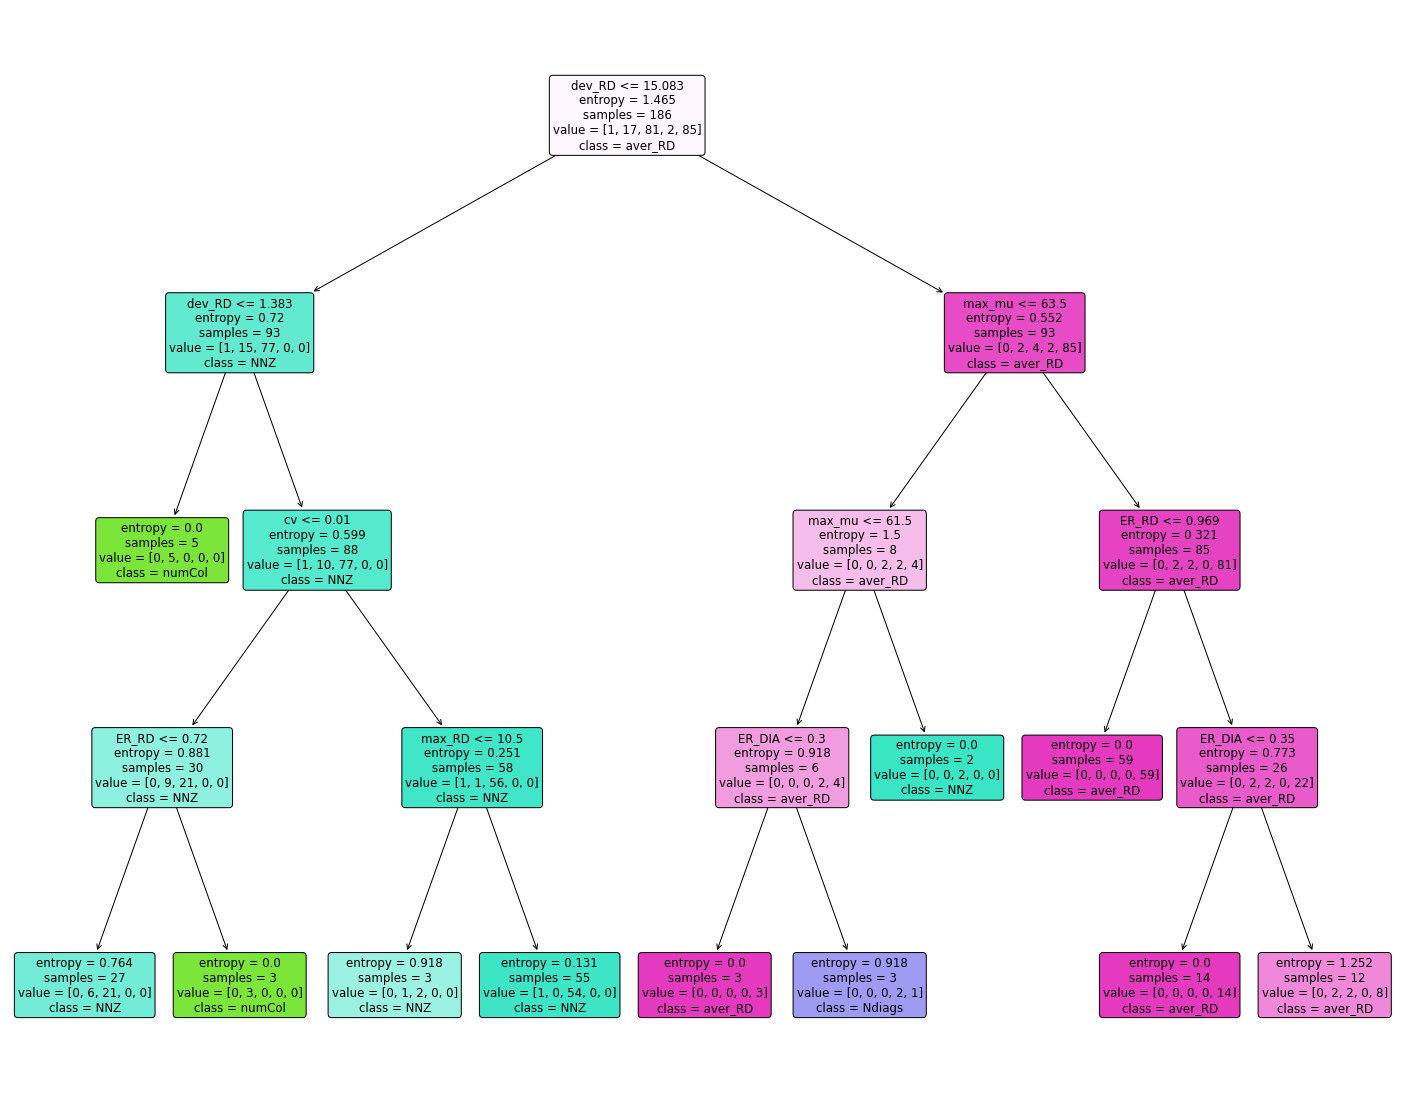

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import rcParams
from termcolor import colored as cl

from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

kf = KFold(n_splits=5)
kf.get_n_splits(X)



# creating accuracy array for storing accuracy from each fold of 5 fold cross validation
accracyArr = numpy.full(5, 0, float)
accuracyCounter = 0
feature_name = name[:-1]

for trainIndex, testIndex in kf.split(X):
#     print("TRAIN: ", trainIndex, "TEST: ", testIndex)
    xTrain, xTest = X[trainIndex], X[testIndex]
    yTrain, yTest = Y[trainIndex], Y[testIndex]
    model_dec = dtc(criterion = 'entropy', max_depth = 4)
    model_dec.fit(xTrain, yTrain)

    start = time.time()
    yPred = model_dec.predict(xTest)
    end = time.time()

    predictions = [round(value) for value in yPred]

    # evaluate predictions
    accracyArr[accuracyCounter] = accuracy_score(yTest, predictions)
    accuracyCounter = accuracyCounter + 1

# taking mean of accuracy of each fold from 5 fold cross validation
accuracyMean = numpy.mean(accracyArr)
print("Accuracy: %.2f%%" % (accuracyMean * 100.0))
print("Inference Time: %.4f" % (end - start))

rcParams['figure.figsize'] = (25, 20)
plot_tree(model_dec, 
          feature_names = feature_name, 
          class_names = name, 
          filled = True, 
          rounded = True)
plt.savefig(saved_model + 'tree_visualization.pdf')

## Below is some test

In [ ]:
name[:-1]

['numRow',
 'numCol',
 'NNZ',
 'Ndiags',
 'aver_RD',
 'max_RD',
 'min_RD',
 'dev_RD',
 'aver_CD',
 'max_CD',
 'min_CD',
 'dev_CD',
 'ER_DIA',
 'ER_RD',
 'ER_CD',
 'row_bounce',
 'col_bounce',
 'density',
 'cv',
 'max_mu']

In [ ]:
dtrain

In [ ]:
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
xTrain.shape,yTrain.shape

((186, 19), (186,))

## Fine-Tuning

In [ ]:
# Grid seach on subsample and max_features
# Choose all predictors except target & IDcols
'''
max_depth: 树的最大深度，这个值也是用来避免过拟合的，max_depth越大，模型会学到更具体更局部的样本，典型值：3-10
min_child_weight: 决定最小叶子节点样本权重和，这个参数用于避免过拟合。
当它的值较大时，可以避免模型学习到局部的特殊样本。 但是如果这个值过高，会导致欠拟合

'''
param_test1 = {
    'max_depth':range(3,10,1),
    'min_child_weight':range(1,6,1)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, n_jobs=4, iid=False, cv=5)
gsearch1.fit(xTrain, yTrain)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'max_depth': range(3, 10),
                         'min_child_weight': range(1, 6)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
 

In [ ]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 5}, 0.41097560975609754)

In [ ]:
'''
gamma: 在节点分裂时，只有分裂后损失函数的值下降了，才会分裂这个节点。
gamma指定了节点分裂所需的最小损失函数下降值。 这个参数的值越大，算法越保守。这个参数的值和损失函数息息相关。
'''

param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=3,
                                        min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test3, n_jobs=4,iid=False, cv=5)
gsearch3.fit(xTrain, yTrain)
gsearch3.best_params_, gsearch3.best_score_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'gamma': 0.0}, 0.8669512195121951)

In [ ]:
'''
subsample: 这个参数控制对于每棵树，随机采样的比例。 
减小这个参数的值，算法会更加保守，避免过拟合。但是，如果这个值设置得过小，它可能会导致欠拟合。 典型值：0.5-1
colsample_bytree: 用来控制每棵随机采样的列数的占比(每一列是一个特征)。 典型值：0.5-1
'''

param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=177, max_depth=3,
                                        min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test4,n_jobs=4,iid=False, cv=5)
gsearch4.fit(xTrain, yTrain)
gsearch4.best_params_, gsearch4.best_score_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'colsample_bytree': 0.6, 'subsample': 0.9}, 0.8815853658536585)

In [ ]:
param_test5 = {
    'subsample':[i/100.0 for i in range(75,90,5)],
    'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=3,
                                        min_child_weight=5, gamma=0, subsample=0.9, colsample_bytree=0.6,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test5, n_jobs=4,iid=False, cv=5)
gsearch5.fit(xTrain, yTrain)
gsearch5.best_params_, gsearch5.best_score_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'colsample_bytree': 0.75, 'subsample': 0.85}, 0.8767073170731707)

In [ ]:
'''
reg_alpha: 权重的L1正则化项。(和Lasso regression类似)。 可以应用在很高维度的情况下，使得算法的速度更快。
'''
param_test6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=3,
                                        min_child_weight=5, gamma=0, subsample=0.9, colsample_bytree=0.6,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test6,n_jobs=4,iid=False, cv=5)
gsearch6.fit(xTrain, yTrain)
gsearch6.best_params_, gsearch6.best_score_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'reg_alpha': 1e-05}, 0.8815853658536585)

In [ ]:
# arr = numpy.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])
# numpy.delete(arr, [1,2], axis=1)

(232, 13)

In [ ]:
'''
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,subsample=0.9,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

'''
# creating accuracy array for storing accuracy from each fold of 5 fold cross validation
accracyArr = numpy.full(5, 0, float)
accuracyCounter = 0

X = dataset.values[:,0:numOfCol-1]
X = numpy.delete(X, [1], axis=1)


for trainIndex, testIndex in kf.split(X):
#     print("TRAIN: ", trainIndex, "TEST: ", testIndex)
    xTrain, xTest = X[trainIndex], X[testIndex]
    # yTrain, yTest = Y[trainIndex], Y[testIndex]
    yTrain, yTest = Y_[trainIndex], Y_[testIndex]

    # fit model on training data
    model_xg = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=177, n_jobs=1, 
              nthread=4, objective='multi:softprob', random_state=0, 
              reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.85, verbosity=1)
    bst = model_xg.fit(xTrain, yTrain)
    bst.save_model('xgb_Time1.model')

    # make predictions for test data
    yPred = model_xg.predict(xTest)
    predictions = [round(value) for value in yPred]

    # evaluate predictions
    accracyArr[accuracyCounter] = accuracy_score(yTest, predictions)
    accuracyCounter = accuracyCounter + 1

# taking mean of accuracy of each fold from 5 fold cross validation
accuracyMean = numpy.mean(accracyArr)
print("Accuracy: %.2f%%" % (accuracyMean * 100.0))

Accuracy: 58.75%


In [ ]:
y_pred = model_xg.predict(xTest)
xTest[25][0]

12400.0

In [ ]:
################ END OF FINE_TUNING #######################

## Feature Importance

In [ ]:
dataset.head(1)

,numRow,numCol,NNZ,Ndiags,aver_RD,max_RD,min_RD,dev_RD,aver_CD,max_CD,min_CD,dev_CD,ER_DIA,ER_RD,ER_CD,row_bounce,col_bounce,density,cv,max_mu,label
0,1000,1000,700000,1999,700.0,748,648,14.64138,700.0,742,656,14.148781,0.35035,0.935829,0.943396,16.5996,16.34034,0.7,0.000383,48.0,2


In [ ]:
model.predict(xTrain)
# xTrain.shape

array([3., 6., 3., 2., 6., 6., 3., 2., 6., 6., 3., 2., 6., 6., 3., 2., 6.,
       6., 3., 2., 6., 6., 3., 3., 6., 6., 3., 3., 6., 6., 3., 3., 6., 6.,
       3., 3., 6., 6., 3., 3., 6., 6., 3., 3., 6., 6., 3., 3., 6., 6., 3.,
       3., 6., 6., 3., 3., 6., 6., 3., 3., 6., 6., 3., 3., 6., 6., 3., 3.,
       6., 6., 3., 3., 6., 6., 3., 3., 6., 6., 3., 3., 6., 6., 3., 3., 6.,
       6., 3., 3., 6., 6., 3., 3., 6., 6., 3., 3., 6., 6., 3., 3., 6., 6.,
       3., 3., 6., 6., 3., 3., 6., 6., 3., 3., 6., 6., 3., 3., 6., 6., 3.,
       3., 6., 6., 3., 3., 6., 6., 3., 3., 6., 6., 3., 3., 6., 6., 3., 3.,
       6., 6., 3., 3., 6., 6., 3., 3., 6., 6., 3., 3., 6., 6., 3., 3., 6.,
       6., 3., 3., 6., 6., 3., 3., 6., 6., 3., 3., 6., 6., 3., 3., 6., 6.,
       3., 3., 6., 6., 3., 3., 6., 6., 3., 3., 6., 6., 3., 3., 6., 6.])

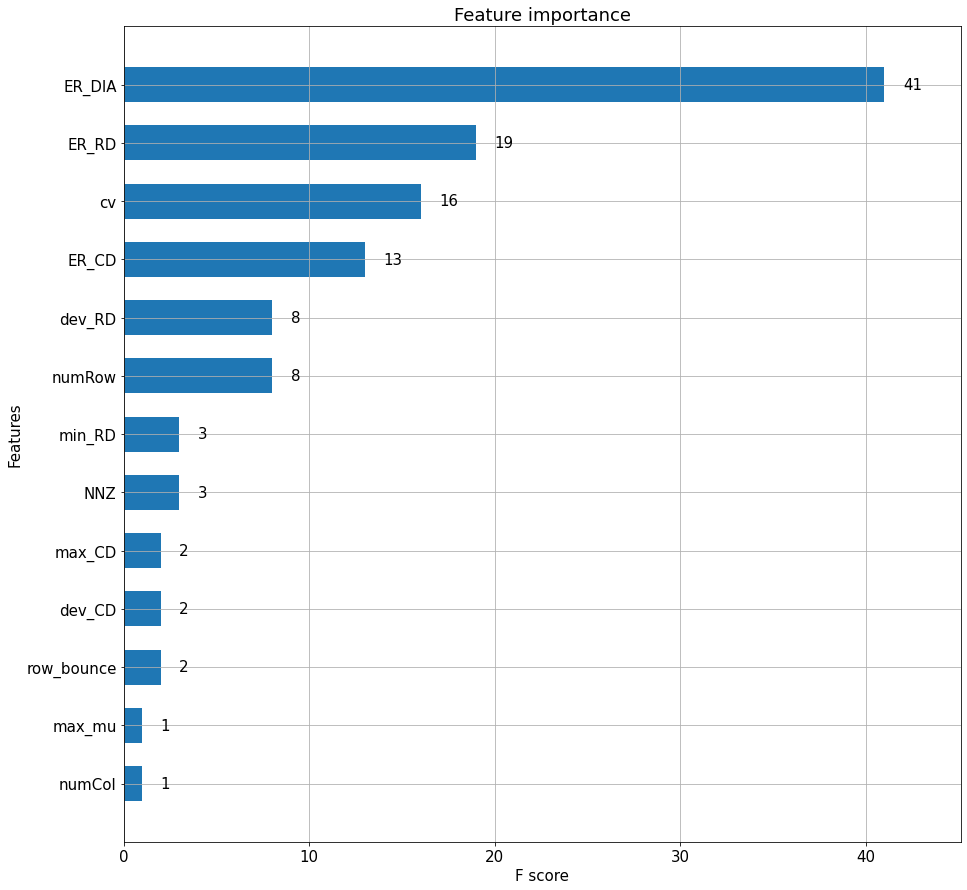

In [ ]:
from xgboost import plot_tree
from xgboost import plot_importance

param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
param['max_depth'] = 5
param['colsample_bytree'] = 0.7
param['gamma'] = 0
param['min_child_weight'] = 3
param['n_estimators'] = 177
param['nthread'] = 4
param['learning_rate'] = 0.01
param['num_class'] = 9

dtrain = xgb.DMatrix(xTrain, label=yTrain, feature_names=feature_name)
model_ = xgb.train(param, dtrain)
fig,ax = plt.subplots(figsize=(15,15))
plt.rcParams.update({'font.size': 15}) 
plot_importance(model_, height=0.6, ax=ax)
plt.savefig('featureimportance.pdf')
plt.show()

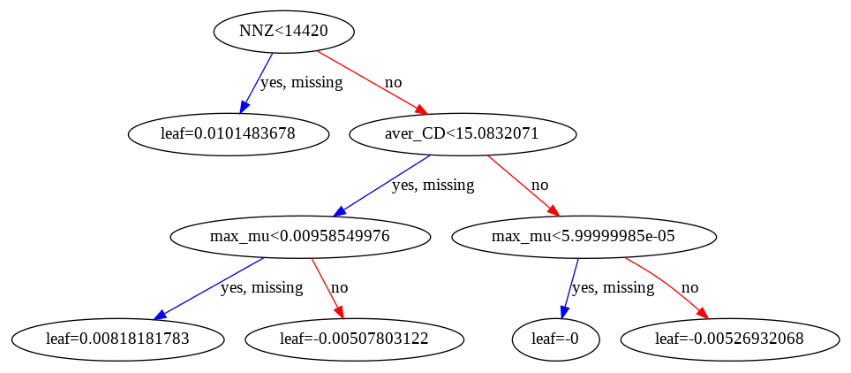

In [ ]:
fig,ax = plt.subplots(figsize=(15,15))
plt.rcParams.update({'font.size': 15}) 
plot_tree(model_, num_trees=2, ax=ax)
plt.savefig('showtree.pdf')
plt.show()

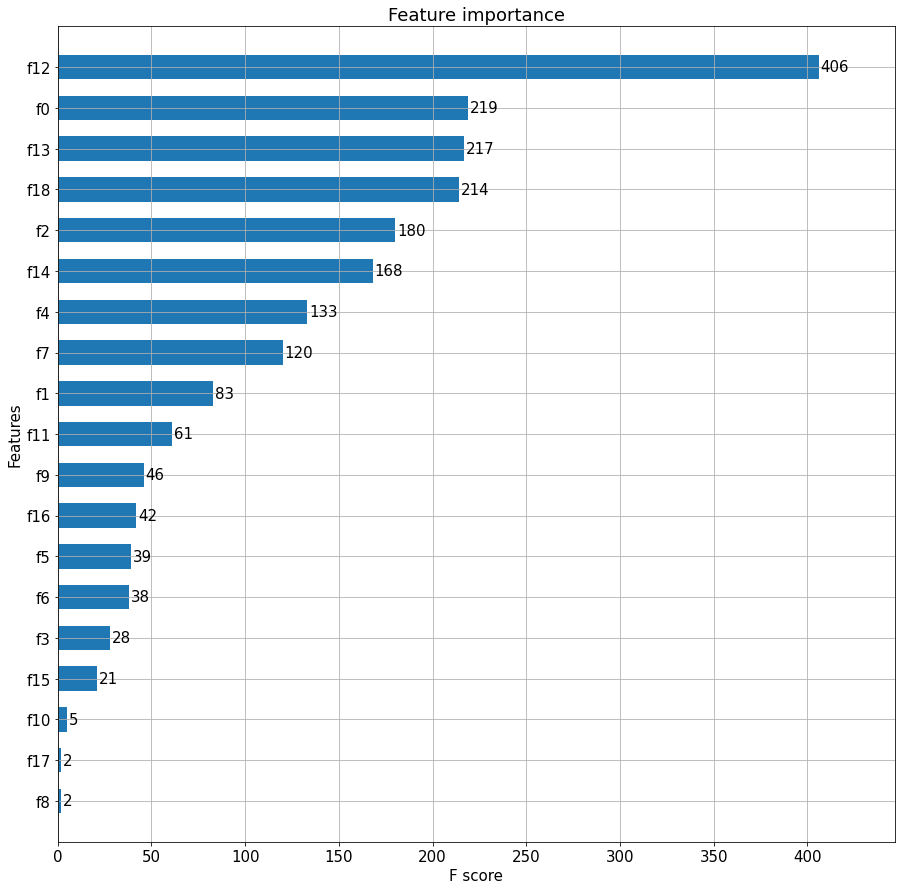

In [ ]:
from xgboost import plot_tree
from xgboost import plot_importance

# load model.
bst = xgb.Booster()
bst.load_model('xgb_Time1.model')
# xgb.to_graphviz(bst)

# print(model.feature_importances_)
fig,ax = plt.subplots(figsize=(15,15))
plt.rcParams.update({'font.size': 15}) 
plot_importance(model, height=0.6, ax=ax)
plt.show()

In [ ]:
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt

# load model.
bst = xgb.Booster()
bst.load_model('xgb_Time.model')

# plot
# plot_tree(bst，fmap='', num_trees=0, rankdir='UT', ax=None)
plt.show()

In [ ]:
len(attribute_feature)

19

In [ ]:
=======================================================================================================================================================================

## Test GCN

In [ ]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric

     |████████████████████████████████| 2.6MB 34.0MB/s 
     |████████████████████████████████| 1.5MB 34.6MB/s 
     |████████████████████████████████| 215kB 28.7MB/s 
     |████████████████████████████████| 235kB 37.0MB/s 
     |████████████████████████████████| 2.2MB 38.5MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 


In [ ]:
# Helper function for visualization.
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.nn import Linear
import torch.nn.functional as F

import torch_geometric.datasets as da
from torch_geometric.transforms import NormalizeFeatures

from collections import Counter
import numpy as np
import pandas as pd

import pickle as pkl
import networkx as nx
import scipy.sparse as sp
import time
import tracemalloc

In [ ]:

dataset_ori = da.Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data_cora = dataset_ori[0]

def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

train_mask = data_cora.train_mask.numpy()
val_mask = data_cora.val_mask.numpy()
test_mask = data_cora.test_mask.numpy()
feature = data_cora.x.numpy()
label = data_cora.y.numpy()
label_oh = np.array(pd.get_dummies(data_cora.y.numpy()))

y_train = np.zeros(label_oh.shape)
y_val = np.zeros(label_oh.shape)
y_test = np.zeros(label_oh.shape)

y_train[train_mask, :] = label_oh[train_mask, :]
y_val[val_mask, :] = label_oh[val_mask, :]
y_test[test_mask, :] = label_oh[test_mask, :]

mat_size = feature.shape[0]
adj_mat = np.zeros((mat_size,mat_size))
edge_index = data_cora.edge_index.numpy()

for i,j in zip(edge_index[0],edge_index[1]):
    adj_mat[i][j] += 1
adj_mat.shape

Processing...
Done!


(2708, 2708)

In [ ]:
def normalize_features(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0. # whether the element is plus or minus infinity
    r_mat_inv = sp.diags(r_inv)
    mx = sp.coo_matrix(mx)
    mx = r_mat_inv.dot(mx)
    return mx

# coordinate list sparse matrix for normalized adjacency matrix
def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.csr_matrix(adj)
    adj += sp.eye(adj.shape[0])
    rowsum = np.array(adj.sum(axis=1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocsr()


start = time.time()
adj_nor = normalize_adj(adj_mat)
feature_nor = normalize_features(feature)
end = time.time()
end - start

0.09754514694213867

### Extract Feature

In [ ]:
# Function to calculate all attributes of a sparse matrix required to train model
def calAttributes(matData, memOrtime='time'):
    if(sp.isspmatrix_coo(matData) == False):
        matData = sp.coo_matrix(matData)
    
    # variable list to store all attributes of sparse matrix required to train model 
    attributeList = []
    
    # Compute the Cost Time of extracting the features
    startTime = time.time()
    
    # writing number of rows and columns in list
    numRows = matData.shape[0]
    numCol = matData.shape[1]
    attributeList.append(numRows)
    attributeList.append(numCol)

    # writing number of non-zeros in list
    nnz = matData.count_nonzero()
    attributeList.append(nnz)

    # writing number of diagonals in list
    # Ndiags = numCol + numRows - 1
    # attributeList.append(Ndiags)

    # attributes for nnzs per row
    rowArr = matData.row
    nnzRows = np.full(matData.shape[0], 0, float)

    for i in range(rowArr.size):
        nnzRows[rowArr[i]] += 1

    aver_RD = np.mean(nnzRows)
    max_RD = np.max(nnzRows)
    min_RD = np.min(nnzRows)
    dev_RD = np.std(nnzRows)

    attributeList.append(aver_RD)
    attributeList.append(max_RD)
    attributeList.append(min_RD)
    attributeList.append(dev_RD)

    #attributes for nnzs per col
    colArr = matData.col
    nnzCol = np.full(matData.shape[1], 0, float)

    for i in range(colArr.size):
        nnzCol[colArr[i]] += 1

    aver_CD = np.mean(nnzCol)
    max_CD = np.max(nnzCol)
    min_CD = np.min(nnzCol)
    dev_CD = np.std(nnzCol)

    attributeList.append(aver_CD)
    attributeList.append(max_CD)
    attributeList.append(min_CD)
    attributeList.append(dev_CD)

    # calculating ER_DIA (Optional)
    matDia = matData.todia()
    matDiaData = matDia.data
    ER_DIA = (np.count_nonzero(matDiaData))/(matDiaData.shape[0]*matDiaData.shape[1])
    attributeList.append(ER_DIA)

    # calculating ER_RD
    ER_RD = nnz/(max_RD*numRows)
    attributeList.append(ER_RD)

    # calculating ER_CD
    ER_CD = nnz/(numCol*max_CD)
    attributeList.append(ER_CD)

    # calculating row_bounce and col_bounce
    diffAdjNnzRows = np.full(nnzRows.size - 1, 0, float)
    for i in range(1,nnzRows.size):
        diffAdjNnzRows[i-1] = np.absolute(nnzRows[i] - nnzRows[i-1])

    row_bounce = np.mean(diffAdjNnzRows)

    diffAdjNnzCols = np.full(nnzCol.size - 1, 0, float)
    for i in range(1,nnzCol.size):
        diffAdjNnzCols[i-1] = np.absolute(nnzCol[i] - nnzCol[i-1])

    col_bounce = np.mean(diffAdjNnzCols)

    attributeList.append(row_bounce)
    attributeList.append(col_bounce)

    # calculating density of matrix
    densityOfMatrix = (matData.count_nonzero())/((matData.shape[0])*(matData.shape[1]))
    attributeList.append(densityOfMatrix)

    # calculating normalized variation of nnz per row
    nnzRowsNormalised = (nnzRows-min_RD)/max_RD
    cv = np.var(nnzRowsNormalised)
    attributeList.append(cv)

    # caluculating max_mu
    max_mu = max_RD - aver_RD
    attributeList.append(max_mu)
    
    # Compute the Cost Time of extracting the features
    endTime = time.time()
    print("Matrix Shape: {}, Extration Time: {}".format(matData.shape[0], round((endTime-startTime),4)))

    return attributeList

In [ ]:
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt
import pickle

# 1: COO, 2: CSR, 3: CSC, 4: BSR, 5: DIA, 6: LIL
index2name = {1:'COO', 2:'CSR', 3:'CSC', 4:'BSR', 5:'DIA', 6:'LIL'}
# load model.
bst = xgb.Booster()
bst.load_model(saved_model + 'xgb_Time1.model')
# bst2 = pickle.loads('pimaSync_pickle.dat')

attributeList = calAttributes(adj_mat)
attributeList_ = np.array(attributeList).reshape(1,19)
test = xgb.DMatrix(attributeList)
index = int(model_xg.predict(attributeList_)[0])
print("Format: ",index2name[index])

Matrix Shape: 2708, Extration Time: 0.0737
Format:  CSC


/usr/local/lib/python3.7/dist-packages/scipy/sparse/coo.py:434: SparseEfficiencyWarning: Constructing a DIA matrix with 3916 diagonals is inefficient
  "is inefficient" % len(diags), SparseEfficiencyWarning)


In [ ]:
def change_format(in_mat):
  start = time.time()
  index2name = {1:'COO', 2:'CSR', 3:'CSC', 4:'BSR', 5:'DIA', 6:'LIL'}
  attributeList = calAttributes(in_mat)
  attributeList_ = np.array(attributeList).reshape(1,19)
  index = int(model_xg.predict(attributeList_)[0])
  end = time.time()
  print("Inference Time: {:.4f}s".format(end - start))
  print("Format: ",index2name[index])

  if index == 1:
    return sp.coo_matrix(in_mat)
  elif index == 2:
    return sp.csr_matrix(in_mat)
  elif index == 3:
    return sp.csc_matrix(in_mat)
  elif index == 4:
    return sp.bsr_matrix(in_mat)
  elif index == 5:
    return sp.dia_matrix(in_mat)
  elif index == 6:
    return sp.lil_matrix(in_mat)

In [ ]:
def softmax(X):
    exp_up = np.exp(X)
    exp_down = np.sum(exp_up,axis=1)[:,np.newaxis] # np.newaxis can add a new axis into the original matrix
    return exp_up/exp_down

def softmax_cross_entropy_deriv(X,Y):
    return X - Y

def relu(X):
    return np.maximum(X, np.zeros(X.shape))

def relu_diff(X):
    return (X>0).astype(int)

class numpyGCN(object):
    """docstring for numpyGCN"""
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=None, weight_decay=0):
        super(numpyGCN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.in_1 = None
        self.out_1 = None
        self.in_2 = None
        self.out_2 = None
        self.random_noise = False

        self.dropout = dropout
        self.weight_decay = weight_decay

        # randomly initialize weight matrices according to Glorot & Bengio (2010)
        self.W_1 = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (input_dim, hidden_dim))
        self.W_2 = np.random.uniform(-np.sqrt(1./output_dim), np.sqrt(1./output_dim), (hidden_dim, output_dim))

    def forward(self, X, A, drop_weights=None):
        W_1 = self.W_1
        W_2 = self.W_2
        
        
        if drop_weights:
            d1, d2 = drop_weights
            W_1 = W_1 * d1
            #W_2 = W_2 * d2
            
        
        self.in_1 = A.dot(X).dot(W_1)
        self.out_1 = relu(self.in_1)
        
        # Change the storing format here
#         self.out_1 = sp.coo_matrix(self.out_1)
#         self.out_1 = sp.csr_matrix(self.out_1)
        self.out_1 = sp.csc_matrix(self.out_1)
#         self.out_1 = sp.dia_matrix(self.out_1)
#         self.out_1 = sp.bsr_matrix(self.out_1)
#         self.out_1 = sp.lil_matrix(self.out_1)
#         self.out_1 = sp.dok_matrix(self.out_1)
        # self.out_1 = change_format(self.out_1)
        
        self.in_2 = A.dot(self.out_1).dot(W_2)
        self.out_2 = softmax(self.in_2)
        
        return self.out_2


    # argmax to predict the label
    def predict(self, X, A):
        out = self.forward(X, A)
        return np.argmax(out, axis=1)


    # returns the accuracy of the classifier
    def compute_accuracy(self, X, Y, A, mask):
        out = self.forward(X, A)
        out_class = np.argmax(out[mask], axis=1)
        expected_class = np.argmax(Y[mask], axis=1)
        num_correct = np.sum(out_class == expected_class).astype(float)

        return num_correct / expected_class.shape[0]

    # normalized cross entropy loss
    def calc_loss(self, X, Y, A, mask):
        N = mask.sum()
        preds = self.forward(X, A)
        loss = np.sum(Y[mask] * np.log(preds[mask]))
        loss = np.asscalar(-loss) / N

        if self.weight_decay:
            l2_reg = np.sum(np.square(self.W_1)) * self.weight_decay / 2
            loss = loss + l2_reg

        return loss

    def loss_accuracy(self, X, Y, A, mask):
        """ Combination of calc_loss and compute_accuracy to reduce the need to forward propagate twice """

        # from calc_loss
        N = mask.sum()
        preds = self.forward(X, A)
        loss = np.sum(Y[mask] * np.log(preds[mask]))
        loss = np.asscalar(-loss) / N

        if self.weight_decay:
            l2_reg = np.sum(np.square(self.W_1)) * self.weight_decay / 2
            loss = loss + l2_reg

        # from compute_accuracy
        out = preds
        out_class = np.argmax(out[mask], axis=1)
        expected_class = np.argmax(Y[mask], axis=1)
        num_correct = np.sum(out_class == expected_class).astype(float)
        accuracy = num_correct / expected_class.shape[0]

        return loss, accuracy

    # back propagation
    def backprop(self, X, Y, A, mask):
        dW_1 = np.zeros(self.W_1.shape)
        dW_2 = np.zeros(self.W_2.shape)

        if self.random_noise:
            tmp_W1, tmp_W2 = np.copy(self.W_1), np.copy(self.W_2)
            self.W_1 += np.random.normal(0, 0.001, self.W_1.shape)
            self.W_2 += np.random.normal(0, 0.001, self.W_2.shape)

        # divide by d so expectation of GCN layer doesn't change from train to test
        if self.dropout:
            d1 = np.random.binomial(1, (1-self.dropout), size=self.W_1.shape) / (1-self.dropout)
            d2 = np.random.binomial(1, (1-self.dropout), size=self.W_2.shape) / (1-self.dropout)
            preds = self.forward(X, A, (d1,d2))
        else:
            preds = self.forward(X, A)
        
        
        # IMPORTANT: update gradient based only on masked labels
        preds[~mask] = Y[~mask]

        # last layer bp for cross entropy loss with softmax activation

        dL_dIn2 = softmax_cross_entropy_deriv(preds, Y)
        dIn2_dW2 = A.dot(self.out_1).transpose()
        # change_format(dL_dIn2)
        dL_dW2 = dIn2_dW2.dot(dL_dIn2)

        # apply backprop for next layer
        dL_dOut1 = A.transpose().dot(dL_dIn2).dot(self.W_2.transpose())
        dOut1_dIn1 = relu_diff(self.in_1)
        dL_dIn1 = dL_dOut1 * dOut1_dIn1
        dIn1_dW1 = A.dot(X).transpose()

        
        dL_dW1 = dIn1_dW1.dot(dL_dIn1)

        if self.weight_decay:
            dL_dW1 += self.weight_decay * self.W_1

        if self.dropout:
            dL_dW1 *= d1
            #dL_dW2 *= d2

        if self.random_noise:
            self.W_1, self.W_2 = tmp_W1, tmp_W2

        return (dL_dW1, dL_dW2)


    def gd_update(self, X, Y, A, mask, lr):
        # compute weight gradients
        dW_1, dW_2 = self.backprop(X, Y, A, mask)

        # parameter update
        self.W_1 -= dW_1 * lr
        self.W_2 -= dW_2 * lr

In [ ]:
def train_with_gd(model, features, adj, y_train, y_val, train_mask, val_mask, early_stopping, lr, epochs):
    t_total = time.time()
    best_val_loss, val_epoch = float('inf'), 0
    past_loss = float('inf')
    elapsed = []
    for epoch in range(epochs):
        start = time.time()
        model.gd_update(features, y_train, adj, train_mask, lr)
        end = time.time()

        train_loss, train_accuracy = model.loss_accuracy(features, y_train, adj, train_mask)
        val_loss, val_accuracy = model.loss_accuracy(features, y_val, adj, val_mask)

        elapsed.append(end - start)
        print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(train_loss),
          "train_acc=", "{:.5f}".format(train_accuracy), "val_loss=", "{:.5f}".format(val_loss),
          "val_acc=", "{:.5f}".format(val_accuracy), "time=", "{:.5f}".format(elapsed[epoch]))

        # decrease the learning rate if the train loss increased
        if train_loss > past_loss:
            lr *= 0.5
        train_loss = min(train_loss, past_loss)

        if early_stopping:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                val_epoch = epoch
            else:
                if epoch - val_epoch == 10:
                    print("validation loss has not improved for 10 epochs... stopping early")
                    break

    print("Total time: {:.4f}s".format(time.time() - t_total))
    return elapsed

In [ ]:
lr = 0.14
early_stopping = 0.00000002
w_d = 0.0008698464584141677
d = 0.0013536140185162625

model = numpyGCN(
        input_dim=feature.shape[1],
        hidden_dim=16,
        output_dim=7,
        dropout=None,
        weight_decay = 0.0008698464584141677
    )

elapsed = train_with_gd(model, feature_nor.tocsc(), adj_nor.tocsc(), y_train, y_val, train_mask, val_mask,
        early_stopping=early_stopping, lr=lr, epochs=200)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Epoch: 0001 train_loss= 2.15254 train_acc= 0.18571 val_loss= 2.15359 val_acc= 0.16000 time= 0.02752
Epoch: 0002 train_loss= 2.15067 train_acc= 0.20714 val_loss= 2.15260 val_acc= 0.19600 time= 0.02869
Epoch: 0003 train_loss= 2.14868 train_acc= 0.26429 val_loss= 2.15152 val_acc= 0.22400 time= 0.02880
Epoch: 0004 train_loss= 2.14645 train_acc= 0.34286 val_loss= 2.15028 val_acc= 0.24000 time= 0.02862
Epoch: 0005 train_loss= 2.14385 train_acc= 0.35714 val_loss= 2.14880 val_acc= 0.26600 time= 0.02904
Epoch: 0006 train_loss= 2.14076 train_acc= 0.38571 val_loss= 2.14702 val_acc= 0.31000 time= 0.03027
Epoch: 0007 train_loss= 2.13698 train_acc= 0.43571 val_loss= 2.14480 val_acc= 0.33400 time= 0.02926
Epoch: 0008 train_loss= 2.13234 train_acc= 0.44286 val_loss= 2.14205 val_acc= 0.36000 time= 0.02967
Epoch: 0009 train_loss= 2.12661 train_acc= 0.45714 val_loss= 2.13859 val_acc= 0.37800 time= 0.02993
Epoch: 0010 train_loss= 2.11948 train_acc= 0.49286 val_loss= 2.13425 val_acc= 0.39200 time= 0.03042


In [ ]:
calAttributes(adj_mat)

Matrix Shape: 2708, Extration Time: 0.1037


/usr/local/lib/python3.7/dist-packages/scipy/sparse/coo.py:434: SparseEfficiencyWarning: Constructing a DIA matrix with 3916 diagonals is inefficient
  "is inefficient" % len(diags), SparseEfficiencyWarning)


[2708,
 2708,
 10556,
 5415,
 3.8980797636632203,
 168.0,
 1.0,
 5.227818372799966,
 3.8980797636632203,
 168.0,
 1.0,
 5.227818372799966,
 0.0009954238415891777,
 0.023202855736090596,
 0.023202855736090596,
 3.0398965644625044,
 3.0398965644625044,
 0.001439468154971647,
 0.000968327839391471,
 164.10192023633678]

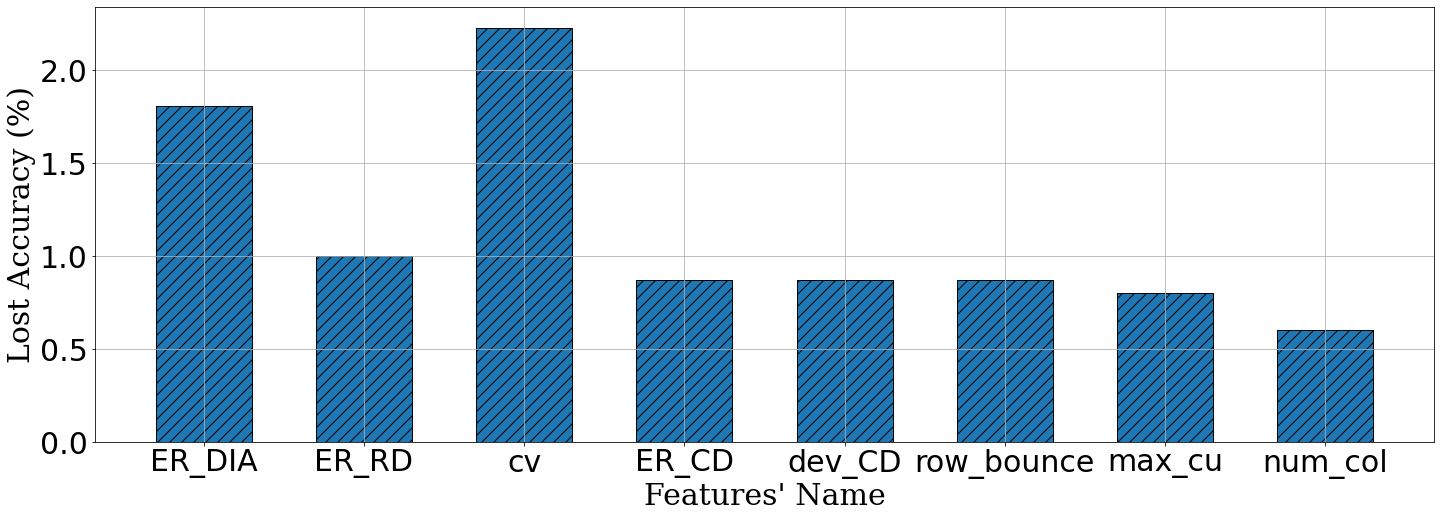

In [ ]:
m_l_name = ['ER_DIA','ER_RD','cv','ER_CD','dev_CD','row_bounce','max_cu','num_col']
loss = [1.81,1,2.23,0.87,0.87,0.87,0.8,0.6]

font2 = {'family':'serif','color':'black','size':30}

plt.figure(figsize=(24,8))
bar_width = 0.6
plt.rcParams.update({'font.size': 30})
plt.bar(x=m_l_name, height=loss, edgecolor='black', hatch="//", width=bar_width, linewidth=1)
plt.ylabel("Lost Accuracy (%)", fontdict = font2)
plt.xlabel("Features' Name", fontdict = font2)
plt.grid(True)
plt.savefig(fname='acclossforfeature.pdf')
plt.show()


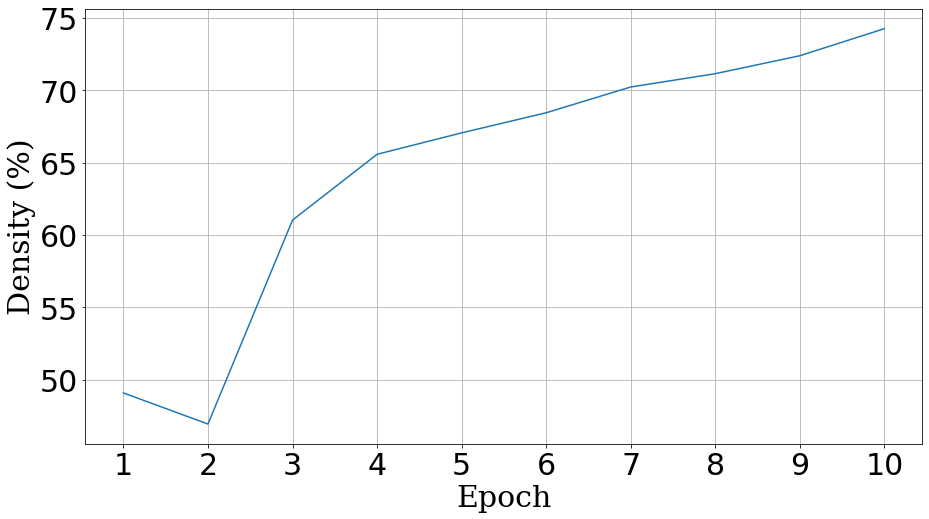

In [ ]:
sparsity = [49.09, 46.94, 61.03, 65.58, 67.06, 68.45, 70.23, 71.15, 72.39, 74.26]

font1 = {'family':'serif','color':'black','size':18}
font2 = {'family':'serif','color':'black','size':30}

plt.figure(figsize=(15,8))
# plt.subplot(121)
plt.rcParams.update({'font.size': 30}) 
plt.plot(range(1, len(sparsity)+1), sparsity, label='First Hidden Layer Output')
# plt.title("GCN Layer's Sparsity", fontdict = font2)
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.xlabel('Epoch', fontdict = font2)
plt.ylabel('Density (%)', fontdict = font2)
plt.grid(True)
# plt.text(1.5, 38, r'(a) The first hidden layer sparsity change', fontsize=16)
plt.savefig(fname='LayerSparsity1.pdf')
plt.show()